In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import datetime
import os

In [2]:
# Use GPU if available for PyTorch
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"

device = torch.device(dev)

In [3]:
def load_data(path, Index=None):
    '''
    Returns 1-D tensor of Open prices
    Moves data to cpu
    
    Args:
        path: path of csv file to open
        Index: specify which company to analyze
    '''

    df = pd.read_csv(path)
    
    if Index:
        df = df[df["Index"] == Index]
    
    df['numerical_date'] = df["Date"].apply(lambda date: datetime.datetime.strptime(date, "%Y-%m-%d"))
    df['x'] = (df["numerical_date"] - df["numerical_date"].min()).dt.days
    
    t = df.loc[:, "Open"].reset_index(drop=True)
    
    data_cpu = torch.tensor(t, dtype=torch.float)
    sub_cpu = torch.tensor(t[:1000], dtype=torch.float)
    
    data = data_cpu.to(device)
    sub = sub_cpu.to(device)

    return df

In [4]:
df = load_data("../data/raw/indexProcessed.csv", "NYA")
df

,Index,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD,numerical_date,x
8492,NYA,1965-12-31,528.690002,528.690002,528.690002,528.690002,528.690002,0.000000e+00,528.690002,1965-12-31,0
8493,NYA,1966-01-03,527.210022,527.210022,527.210022,527.210022,527.210022,0.000000e+00,527.210022,1966-01-03,3
8494,NYA,1966-01-04,527.840027,527.840027,527.840027,527.840027,527.840027,0.000000e+00,527.840027,1966-01-04,4
8495,NYA,1966-01-05,531.119995,531.119995,531.119995,531.119995,531.119995,0.000000e+00,531.119995,1966-01-05,5
8496,NYA,1966-01-06,532.070007,532.070007,532.070007,532.070007,532.070007,0.000000e+00,532.070007,1966-01-06,6
...,...,...,...,...,...,...,...,...,...,...,...
22434,NYA,2021-05-24,16375.000000,16508.519530,16375.000000,16464.689450,16464.689450,2.947400e+09,16464.689450,2021-05-24,20233
22435,NYA,2021-05-25,16464.689450,16525.810550,16375.150390,16390.189450,16390.189450,3.420870e+09,16390.189450,2021-05-25,20234
22436,NYA,2021-05-26,16390.189450,16466.339840,16388.320310,16451.960940,16451.960940,3.674490e+09,16451.960940,2021-05-26,20235
22437,NYA,2021-05-27,16451.960940,16546.359380,16451.960940,16531.949220,16531.949220,5.201110e+09,16531.949220,2021-05-27,20236


In [64]:
# keep track of duration and slope
# slope = (d[i] - d[j]) / (i - j)
# duration = i - j

def convert_to_trend(d, max_error, min_segment_length):
    '''
    Convert 1-D tensor of Open costs to 2-D tensor of trend durations and slopes
    '''
    len_x = d.shape[0]
    x = np.array(d["x"])
    y = np.array(d["Open"])
    
    # set buffer and lower and upper bounds
    w = len_x // 7 # buffer ensures that there is enough data for 5 to 6 segments as specified in original paper
    lower_bound = w // 2
    upper_bound = int(2 * w)
    
    sequences = []
    
    i = 0
    while i < len_x:
        # bottom_up
        sequences += bottom_up(x, y, i, w, max_error, min_segment_length)
        
        # slide window
        i = w
        w = min(i + int(min(upper_bound, max(lower_bound, best_line(x, y, i, max_error, upper_bound)))), len_x)
        

    trends = [[None, None, None] for _ in range(len(sequences))]
    for idx, sequence in enumerate(sequences):
        trends[idx][0] = min_segment_length # duration
        trends[idx][1] = __calculate_slope(x, y, sequence[0], sequence[1])
        trends[idx][2] = [y[i] for i in range(sequence[0], sequence[1])]
        
#     return torch.tensor(trends, dtype=torch.float)
    return trends
        
        
def __calculate_error(x, y, i, j):
    curr_x, curr_y = x[i:j+1], y[i:j+1]
    A = np.vstack([curr_x, np.ones(len(curr_x))]).T
    try:
        error = np.linalg.lstsq(A, curr_y, rcond=None)[1][0]
    except IndexError:
        error = 0

    return error


def __calculate_slope(x, y, i, j):
    curr_x, curr_y = x[i:j+1], y[i:j+1]
    A = np.vstack([curr_x, np.ones(len(curr_x))]).T
    try:
        m, c = np.linalg.lstsq(A, curr_y, rcond=None)[0]
    except IndexError:
        m = 0

    return m


def __calculate_intercept(x, y, i, j):
    curr_x, curr_y = x[i:j+1], y[i:j+1]
    A = np.vstack([curr_x, np.ones(len(curr_x))]).T
    try:
        m, c = np.linalg.lstsq(A, curr_y, rcond=None)[0]
    except IndexError:
        c = 0

    return c


def best_line(x, y, i, max_error, upper_bound):
    '''
    Return indices for next segment
    '''
    error = 0
    j = i
    while error <= max_error and j < upper_bound:
        j += 15
        curr_x, curr_y = x[i:j], y[i:j]
        error = __calculate_error(curr_x, curr_y, i, j)

    return j


def bottom_up(x, y, i, j, max_error, min_segment_length):
    '''
    Performs bottom up algorithm
    '''
    print(f"Performing bottom_up with i={i}, j={j}, max_error={max_error}")
    segments = [[k, k+2] for k in range(i, j, 2)]

    fully_merged = False
    while not fully_merged:

        min_merge_error, min_merge_idx = float("inf"), None
        min_seg_length, min_seg_idx = float("inf"), None
        
        # get min error
        for idx in range(0, len(segments)-1, 2):
            curr_error = __calculate_error(x, y, segments[idx][0], segments[idx+1][1])
            if curr_error < min_merge_error:
                min_merge_error = curr_error
                min_merge_idx = idx
        
        # get min segment length
        for idx in range(len(segments)):
            if segments[idx][1] - segments[idx][0] < min_seg_length:
                min_seg_length = segments[idx][1] - segments[idx][0]
                min_seg_idx = idx
        
        # merge segments if needed
        if min_merge_error < max_error:
            segments[min_merge_idx] = [segments[min_merge_idx][0], min(len(x)-1, segments[min_merge_idx+1][1])]
            segments.pop(min_merge_idx+1)
            
        elif min_seg_length < min_segment_length:
            if min_seg_idx == len(segments)-1:
                min_seg_idx -= 1
                
            segments[min_seg_idx] = [segments[min_seg_idx][0], min(len(x)-1, segments[min_seg_idx+1][1])]
            segments.pop(min_seg_idx+1)
            
        else:
            fully_merged = True
            
#     print(f"Length of segments: {len(segments)}")
    return segments

In [65]:
converted_data = convert_to_trend(df, max_error=1000, min_segment_length=10)

Performing bottom_up with i=0, j=1992, max_error=1000
Performing bottom_up with i=1992, j=5976, max_error=1000
Performing bottom_up with i=5976, j=9960, max_error=1000
Performing bottom_up with i=9960, j=13944, max_error=1000
Performing bottom_up with i=13944, j=13947, max_error=1000


In [51]:
x = np.array(df["x"])
y = np.array(df["Open"])

A = np.vstack([x, np.ones(len(x))]).T
m, c = np.linalg.lstsq(A, y, rcond=None)[0]
m, c

(0.6535200319396268, -2168.561532783659)

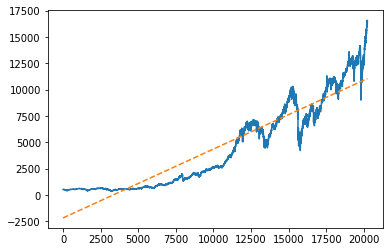

In [52]:
plt.plot(x, y)
x_vals = np.array(x)
y_vals = c + m * x_vals
plt.plot(x_vals, y_vals, '--')

In [13]:
# last column = all data points that make up the trend